<div style="border: 5px dotted #2980B9; padding: 10px; background-color: #F0F0F0; border-radius: 10px; display: block; width: 100%; text-align: center; font-size: 2em;">
    <strong><span style="color:#FF6B6B"> Brain-to-Text '25 </span> || <span style="color:#9B59B6">An Introductory</span> <span style="color:#2980B9"> EDA</span></strong>
</div>

------
### Competition link: [Brain-to-text '25](https://www.kaggle.com/competitions/brain-to-text-25/overview)

-----


In [1]:
from IPython.display import Image, display,  Markdown
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
# Brain-to-Text Transformer Decoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import random
from collections import Counter

In [2]:
markdown_text = """
I have done some digging to try and understand this competition and here are some of the inisghts I have gathered. 

This competition is based on the remarkable work published in the *New England Journal of Medicine*:
> **"An Accurate and Rapidly Calibrating Speech Neuroprosthesis"** by Card et al. (2024). [@notnickc](https://www.kaggle.com/notnickc)

The paper describes a brain-computer interface (BCI) that allowed a man with severe paralysis from ALS to communicate by decoding his attempted speech directly from brain activity. This dataset contains the neural recordings and corresponding text from that research participant, identified as **T15**.

**The goal here is to build models that can map the raw neural time-series data to the intended text.**

### Notebook Goals
1.  **Understand the Experimental Setup**: Briefly review the context from the NEJM paper.
2.  **Load and Structure the Data**: Process the HDF5 files into a manageable format.
3.  **Analyze the Target Sentences**: Explore the length, vocabulary, and characteristics of what the participant was asked to say.
4.  **Dive into the Neural Data**: Investigate trial durations, speaking rates, and the activity patterns across different brain regions.
5.  **Connect Neural Activity to Speech**: Visualize how neural signals correspond to spoken sentences.
"""

display(Markdown(markdown_text))


I have done some digging to try and understand this competition and here are some of the inisghts I have gathered. 

This competition is based on the remarkable work published in the *New England Journal of Medicine*:
> **"An Accurate and Rapidly Calibrating Speech Neuroprosthesis"** by Card et al. (2024). [@notnickc](https://www.kaggle.com/notnickc)

The paper describes a brain-computer interface (BCI) that allowed a man with severe paralysis from ALS to communicate by decoding his attempted speech directly from brain activity. This dataset contains the neural recordings and corresponding text from that research participant, identified as **T15**.

**The goal here is to build models that can map the raw neural time-series data to the intended text.**

### Notebook Goals
1.  **Understand the Experimental Setup**: Briefly review the context from the NEJM paper.
2.  **Load and Structure the Data**: Process the HDF5 files into a manageable format.
3.  **Analyze the Target Sentences**: Explore the length, vocabulary, and characteristics of what the participant was asked to say.
4.  **Dive into the Neural Data**: Investigate trial durations, speaking rates, and the activity patterns across different brain regions.
5.  **Connect Neural Activity to Speech**: Visualize how neural signals correspond to spoken sentences.


In [3]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# --- Style and Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk") # 'talk' context for larger, more readable plots
pd.set_option('display.max_colwidth', 100) # Show more of the sentence text

# --- Constants ---
BASE_DIR = '/brain-to-text-25/t15_copyTask_neuralData/hdf5_data_final'

In [4]:
##
markdown_text = """
## Part 1: The Participant and the Experiment

Before we look at the data, let's understand where it comes from.

-   **Participant (T15)**: A man with amyotrophic lateral sclerosis (ALS) and severe dysarthria (difficulty speaking).
-   **Implants**: Four 64-channel microelectrode arrays (256 electrodes total) were implanted in his **left precentral gyrus**, a key area for speech motor control.
-   **Neural Features**: For each of the 256 electrodes, two features were extracted:
    1.  **Threshold Crossings**: The rate at which the neural signal crosses a certain voltage threshold (a proxy for neuronal firing rate).
    2.  **Spike Band Power (SBP)**: The power of the signal in the frequency range typical for neuron spikes.
-   **Total Features**: This gives us **256 electrodes * 2 features/electrode = 512 neural features** per time step.

### Mapping Features to Brain Regions

The NEJM paper and competition description tell us exactly which brain areas the four arrays targeted. This is crucial information!

| Array Location                 | Electrode Indices | Feature Indices (Threshold Crossings) | Feature Indices (Spike Band Power) |
| ------------------------------ | ----------------- | ------------------------------------- | ---------------------------------- |
| Ventral Premotor Cortex (6v)   | 0-63              | 0-63                                  | 256-319                            |
| Primary Motor Cortex (Area 4)  | 64-127            | 64-127                                | 320-383                            |
| Area 55b (Language-related)    | 128-191           | 128-191                               | 384-447                            |
| Dorsal Premotor Cortex (6v)    | 192-255           | 192-255                               | 448-511                            |
"""

display(Markdown(markdown_text))


## Part 1: The Participant and the Experiment

Before we look at the data, let's understand where it comes from.

-   **Participant (T15)**: A man with amyotrophic lateral sclerosis (ALS) and severe dysarthria (difficulty speaking).
-   **Implants**: Four 64-channel microelectrode arrays (256 electrodes total) were implanted in his **left precentral gyrus**, a key area for speech motor control.
-   **Neural Features**: For each of the 256 electrodes, two features were extracted:
    1.  **Threshold Crossings**: The rate at which the neural signal crosses a certain voltage threshold (a proxy for neuronal firing rate).
    2.  **Spike Band Power (SBP)**: The power of the signal in the frequency range typical for neuron spikes.
-   **Total Features**: This gives us **256 electrodes * 2 features/electrode = 512 neural features** per time step.

### Mapping Features to Brain Regions

The NEJM paper and competition description tell us exactly which brain areas the four arrays targeted. This is crucial information!

| Array Location                 | Electrode Indices | Feature Indices (Threshold Crossings) | Feature Indices (Spike Band Power) |
| ------------------------------ | ----------------- | ------------------------------------- | ---------------------------------- |
| Ventral Premotor Cortex (6v)   | 0-63              | 0-63                                  | 256-319                            |
| Primary Motor Cortex (Area 4)  | 64-127            | 64-127                                | 320-383                            |
| Area 55b (Language-related)    | 128-191           | 128-191                               | 384-447                            |
| Dorsal Premotor Cortex (6v)    | 192-255           | 192-255                               | 448-511                            |


In [5]:
url = "https://www.nejm.org/cms/10.1056/NEJMoa2314132/asset/4b12cab0-da95-41fe-ae13-092148a7657c/assets/images/large/nejmoa2314132_f1.jpg"

display(Image(url=url))

caption = """
We will use this mapping to analyze the data.
"""
display(Markdown(caption))


We will use this mapping to analyze the data.


In [6]:
markdown_text = """
## Part 2: Loading and Structuring the Data

The data is organized into sessions by date, with `train`, `val`, and `test` splits in HDF5 files. Let's load the metadata (everything except the large neural data arrays) into a single pandas DataFrame for easy analysis.
"""

display(Markdown(markdown_text))


## Part 2: Loading and Structuring the Data

The data is organized into sessions by date, with `train`, `val`, and `test` splits in HDF5 files. Let's load the metadata (everything except the large neural data arrays) into a single pandas DataFrame for easy analysis.


In [7]:
import h5py
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os


BASE_DIR = 'brain-to-text-25/t15_copyTask_neuralData/hdf5_data_final'

NEURAL_DATA_KEY = 'input_features'
TRANSCRIPTION_KEY = 'transcription'

def load_metadata_from_hdf5(file_path):
    metadata = []
    try:
        with h5py.File(file_path, 'r') as f:
            # The top-level keys ARE the trials.
            for trial_key in f.keys():
                trial_group = f[trial_key]
                
                # Check if the group contains the correct dataset names
                if isinstance(trial_group, h5py.Group) and NEURAL_DATA_KEY in trial_group and TRANSCRIPTION_KEY in trial_group:
                    
                    num_time_bins = trial_group[NEURAL_DATA_KEY].shape[0]
                    
                    # The transcription is an array of integers, not a string.
                    # We will load it as a list of numbers for now.
                    transcription_ids = list(trial_group[TRANSCRIPTION_KEY][()])
                    
                    metadata.append({
                        'trial_id': trial_key,
                        'num_time_bins': num_time_bins,
                        'transcription_ids': transcription_ids,
                        # We can't get num_words directly yet, so we'll estimate from the length of the ID list.
                        # This might not be perfect but is a good start.
                        'num_words_estimate': len(transcription_ids) 
                    })
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        import traceback
        traceback.print_exc()
        
    return metadata

def load_test_metadata_from_hdf5(file_path):
    """ Loads test data which only has input_features. """
    metadata = []
    try:
        with h5py.File(file_path, 'r') as f:
            for trial_key in f.keys():
                trial_group = f[trial_key]
                if isinstance(trial_group, h5py.Group) and NEURAL_DATA_KEY in trial_group:
                    num_time_bins = trial_group[NEURAL_DATA_KEY].shape[0]
                    metadata.append({
                        'trial_id': trial_key,
                        'num_time_bins': num_time_bins
                    })
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
    return metadata


all_metadata = []
session_dirs = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))])

for session in tqdm(session_dirs, desc="Processing Sessions"):
    session_path = os.path.join(BASE_DIR, session)
    for split in ['train', 'val']:
        file_name = f'data_{split}.hdf5'
        file_path = os.path.join(session_path, file_name)
        
        if os.path.exists(file_path):
            if split == 'test':
                session_metadata = load_test_metadata_from_hdf5(file_path)
            else:
                session_metadata = load_metadata_from_hdf5(file_path)
            
            # Add session and split info to the found trials
            for item in session_metadata:
                item['session'] = session
                item['split'] = split
            all_metadata.extend(session_metadata)

df = pd.DataFrame(all_metadata)

print(f"Loaded a total of {len(df)} trials.")
if not df.empty:
    print(f"Data splits:\n{df['split'].value_counts()}")
    # We no longer have 'sentence_text', so display the new columns
    display(df.head())
else:
    print("DataFrame is still empty. This indicates a very unusual issue.")

Processing Sessions:   0%|          | 0/45 [00:00<?, ?it/s]

Loaded a total of 9498 trials.
Data splits:
split
train    8072
val      1426
Name: count, dtype: int64


,trial_id,num_time_bins,transcription_ids,num_words_estimate,session,split
0,trial_0000,321,"[66, 114, 105, 110, 103, 32, 105, 116, 32, 99, 108, 111, 115, 101, 114, 46, 0, 0, 0, 0, 0, 0, 0,...",500,t15.2023.08.11,train
1,trial_0001,481,"[77, 121, 32, 102, 97, 109, 105, 108, 121, 32, 105, 115, 32, 99, 108, 111, 115, 101, 114, 46, 0,...",500,t15.2023.08.11,train
2,trial_0002,480,"[87, 104, 97, 116, 32, 100, 111, 32, 116, 104, 101, 121, 32, 108, 105, 107, 101, 63, 0, 0, 0, 0,...",500,t15.2023.08.11,train
3,trial_0003,502,"[72, 111, 119, 32, 105, 115, 32, 116, 104, 97, 116, 32, 103, 111, 111, 100, 63, 0, 0, 0, 0, 0, 0...",500,t15.2023.08.11,train
4,trial_0004,402,"[78, 101, 101, 100, 32, 104, 101, 108, 112, 32, 104, 101, 114, 101, 63, 0, 0, 0, 0, 0, 0, 0, 0, ...",500,t15.2023.08.11,train


In [8]:
markdown_text = """
### **Part 3: Analyzing the Sentences (The "What")**

The sentences are now encoded as lists of integers (`transcription_ids`).

Looking at the first few `transcription_ids` like `[66, 114, 105, 110, 103, 32, ...]` and the common `32`, it's highly likely this is a simple **ASCII or Unicode character encoding**. Let's test this hypothesis.

*   `chr(32)` is a space ' '
*   `chr(66)` is 'B'
*   `chr(114)` is 'r'

We write a function to decode these IDs back into human-readable text and add it to DataFrame. We also need to handle the zero-padding at the end of the lists.
"""

display(Markdown(markdown_text))


### **Part 3: Analyzing the Sentences (The "What")**

The sentences are now encoded as lists of integers (`transcription_ids`).

Looking at the first few `transcription_ids` like `[66, 114, 105, 110, 103, 32, ...]` and the common `32`, it's highly likely this is a simple **ASCII or Unicode character encoding**. Let's test this hypothesis.

*   `chr(32)` is a space ' '
*   `chr(66)` is 'B'
*   `chr(114)` is 'r'

We write a function to decode these IDs back into human-readable text and add it to DataFrame. We also need to handle the zero-padding at the end of the lists.


In [9]:
# Fixed version of decode_transcription function
def decode_transcription_fixed(ids):
    """Converts a list of ASCII character IDs to a string, stopping at the first null character."""
    # The transcription is zero-padded, so we find the first 0 and take everything before it.
    try:
        # Convert to numpy array if it isn't already, then find first zero
        ids_array = np.array(ids)
        zero_indices = np.where(ids_array == 0)[0]
        if len(zero_indices) > 0:
            first_zero = zero_indices[0]
            char_list = [chr(c) for c in ids[:first_zero]]
        else:
            char_list = [chr(c) for c in ids]
    except (ValueError, TypeError): # If no zero is found or other error
        char_list = [chr(c) for c in ids]
        
    return "".join(char_list)

# Test the function with a sample
test_ids = np.array([72, 101, 108, 108, 111, 0, 0, 0])  # "Hello" with padding
print("Test result:", decode_transcription_fixed(test_ids))


Test result: Hello


In [10]:
import warnings
warnings.filterwarnings('ignore')
def decode_transcription(ids):
    """Converts a list of ASCII character IDs to a string, stopping at the first null character."""
    # The transcription is zero-padded, so we find the first 0 and take everything before it.
    try:
        first_zero = ids.index(0)
        char_list = [chr(c) for c in ids[:first_zero]]
    except ValueError: # If no zero is found
        char_list = [chr(c) for c in ids]
        
    return "".join(char_list)

# Apply this decoding to our DataFrame
# We'll only do this for the train/val sets where we have the labels
labeled_df = df[df['split'] != 'test'].copy()
labeled_df['sentence_text'] = labeled_df['transcription_ids'].apply(decode_transcription)

# Now we can calculate the true number of words
labeled_df['num_words'] = labeled_df['sentence_text'].apply(lambda x: len(x.split()))

# Let's merge this back into the main DataFrame
df = pd.merge(df, labeled_df[['session', 'trial_id', 'sentence_text', 'num_words']], on=['session', 'trial_id'], how='left')

# Fill NaN for the test set where we don't have text
df['sentence_text'].fillna('[held-out]', inplace=True)

print("Decoding complete. Here's a sample of the decoded text:")
display(df.head())

Decoding complete. Here's a sample of the decoded text:


,trial_id,num_time_bins,transcription_ids,num_words_estimate,session,split,sentence_text,num_words
0,trial_0000,321,"[66, 114, 105, 110, 103, 32, 105, 116, 32, 99, 108, 111, 115, 101, 114, 46, 0, 0, 0, 0, 0, 0, 0,...",500,t15.2023.08.11,train,Bring it closer.,3
1,trial_0001,481,"[77, 121, 32, 102, 97, 109, 105, 108, 121, 32, 105, 115, 32, 99, 108, 111, 115, 101, 114, 46, 0,...",500,t15.2023.08.11,train,My family is closer.,4
2,trial_0002,480,"[87, 104, 97, 116, 32, 100, 111, 32, 116, 104, 101, 121, 32, 108, 105, 107, 101, 63, 0, 0, 0, 0,...",500,t15.2023.08.11,train,What do they like?,4
3,trial_0003,502,"[72, 111, 119, 32, 105, 115, 32, 116, 104, 97, 116, 32, 103, 111, 111, 100, 63, 0, 0, 0, 0, 0, 0...",500,t15.2023.08.11,train,How is that good?,4
4,trial_0004,402,"[78, 101, 101, 100, 32, 104, 101, 108, 112, 32, 104, 101, 114, 101, 63, 0, 0, 0, 0, 0, 0, 0, 0, ...",500,t15.2023.08.11,train,Need help here?,3


### Sentence Length Distribution

## Vocabulary Size

****A Quick Note on the Vocabulary****: The text hasn't been filtered for sensitive content. You may encounter words that are profane or offensive.

In [11]:
# We need to tokenize the sentences to count unique words
all_words = ' '.join(df[df['split'] != 'test']['sentence_text']).lower().split()
vocabulary = set(all_words)

print(f"Total number of words (tokens): {len(all_words)}")
print(f"Vocabulary size (unique words): {len(vocabulary)}")
print("\nSome example words from the vocabulary:")
# Filter out any empty strings that might result from splitting
print([word for word in list(vocabulary) if word][:15])

Total number of words (tokens): 78602
Vocabulary size (unique words): 5979

Some example words from the vocabulary:
['injury.', 'bow', 'adolescents.', 'jury.', 'is?', 'shortly', 'schools', 'spend.', 'choosing', 'spending', 'presidential', 'material.', 'hawaii', 'persian', 'saying']


In [30]:
train_data = []

for session in tqdm(session_dirs, desc="Обработка сессий"):
    session_path = os.path.join(BASE_DIR, session)
    file_path = os.path.join(session_path, 'data_train.hdf5')
    
    if os.path.exists(file_path):
        if 'train' not in file_path:
            continue
        with h5py.File(file_path, 'r') as f:
            for trial_key in f.keys():
                trial_group = f[trial_key]
                
                if isinstance(trial_group, h5py.Group) and NEURAL_DATA_KEY in trial_group:
                    neural_data = trial_group[NEURAL_DATA_KEY][()]
                    # print(trial_group.keys())
                    phonems = trial_group['seq_class_ids'][()]
                    
                    transcription_text = None
                    if TRANSCRIPTION_KEY in trial_group:
                        transcription_ids = trial_group[TRANSCRIPTION_KEY][()]
                        transcription_text = decode_transcription_fixed(transcription_ids)
                    
                    train_data.append({
                        'session': session,
                        'trial_id': trial_key,
                        'neural_data': neural_data,
                        'transcription': transcription_text,
                        'num_time_bins': neural_data.shape[0],
                        'num_features': neural_data.shape[1],
                        'phonems': phonems,
                        'num_words': len(transcription_text.split()) if transcription_text else 0,
                    })

# Создаем DataFrame
train_df = pd.DataFrame(train_data)


Обработка сессий:   0%|          | 0/45 [00:00<?, ?it/s]

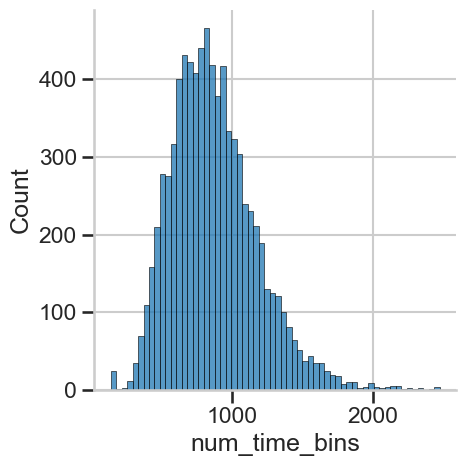

In [13]:
sns.displot(train_df['num_time_bins'])

In [14]:
train_df.head()

,session,trial_id,neural_data,transcription,num_time_bins,num_features,duration_seconds,num_words
0,t15.2023.08.11,trial_0000,"[[2.3076649, -0.78699756, -0.64687246, -0.5465877, 0.25500455, -0.37754795, -0.31888878, -0.4374...",Bring it closer.,321,512,6.42,3
1,t15.2023.08.11,trial_0001,"[[-0.51709145, -0.70207363, -0.64330804, -0.4804889, -0.74278086, -0.3836035, 4.4708495, -0.3822...",My family is closer.,481,512,9.62,4
2,t15.2023.08.11,trial_0002,"[[0.95464545, -0.6912571, 2.5334082, -0.45932075, -0.6866933, -0.36051196, -0.31188744, -0.38424...",What do they like?,480,512,9.60,4
3,t15.2023.08.11,trial_0003,"[[-0.4997814, -0.6836047, -0.6305947, 1.2600378, 1.6435596, -0.36407253, -0.2934556, -0.37197226...",How is that good?,502,512,10.04,4
4,t15.2023.08.11,trial_0004,"[[-0.4850082, -0.66607094, -0.62398034, -0.43359536, -0.6746259, -0.36549258, -0.2977266, -0.369...",Need help here?,402,512,8.04,3


In [15]:
train_df.iloc[0]['neural_data'].shape

(321, 512)

Корелляция датчиков.

Text(187.94444444444446, 0.5, 'Датчики')

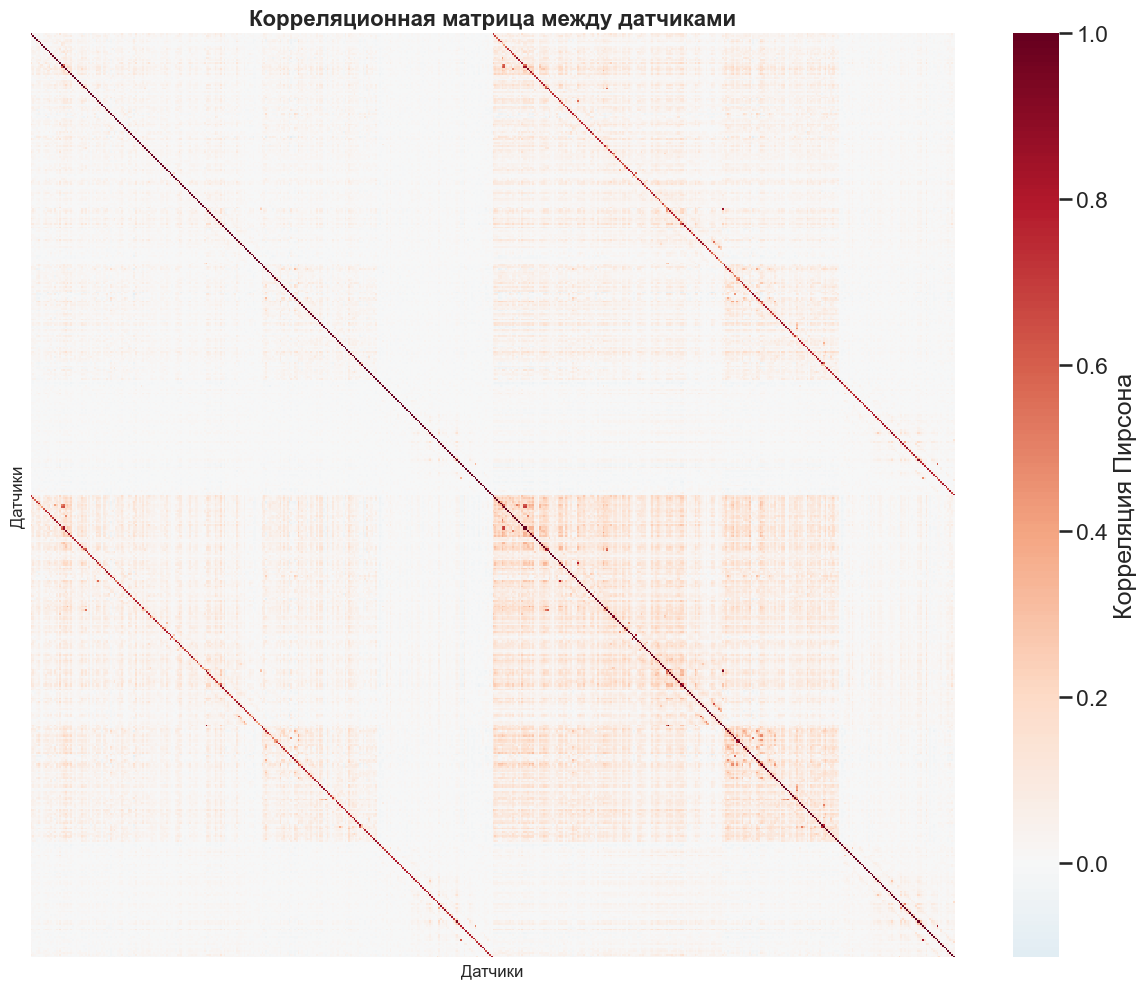

In [16]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


all_sensor_data = []
sensor_names = []

sample_trials = train_df.head(100)

for idx, row in sample_trials.iterrows():
    neural_data = row['neural_data']  # shape: (time_bins, num_sensors)
    
    sensor_data = neural_data.T
    
    if len(all_sensor_data) == 0:
        # Инициализируем массив при первом триале
        all_sensor_data = sensor_data
        sensor_names = [f'Sensor_{i}' for i in range(sensor_data.shape[0])]
    else:
        # Конкатенируем данные по времени
        all_sensor_data = np.concatenate([all_sensor_data, sensor_data], axis=1)
correlation_matrix = np.corrcoef(all_sensor_data)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            cbar_kws={'label': 'Корреляция Пирсона'},
            xticklabels=False,
            yticklabels=False)

plt.title('Корреляционная матрица между датчиками', fontsize=16, fontweight='bold')
plt.xlabel('Датчики', fontsize=12)
plt.ylabel('Датчики', fontsize=12)


### **Part 4: Diving into the Neural Data (The "How")**


#### Trial Duration and Speaking Rate

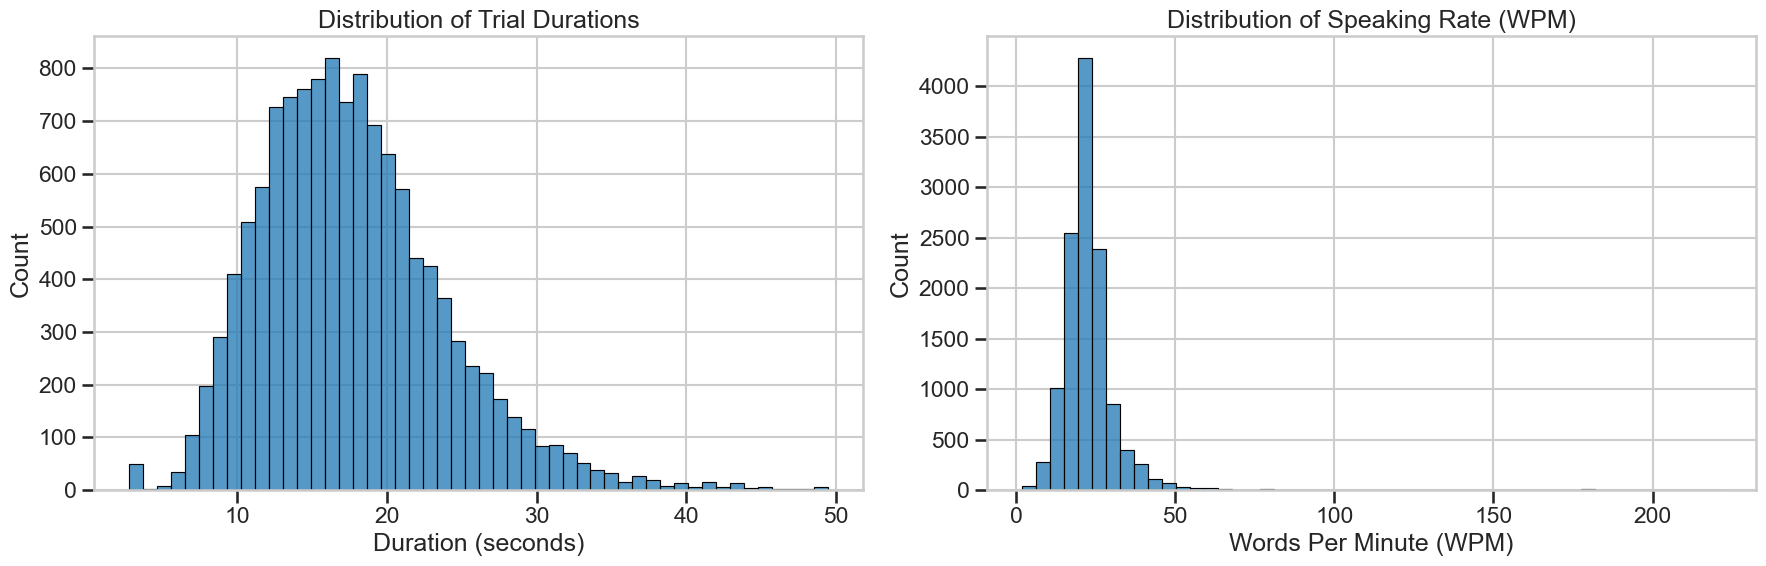

In [17]:
# Duration in seconds = num_time_bins * 0.02
df['duration_s'] = df['num_time_bins'] * 0.02

# Words Per Minute (WPM) = (num_words / duration_s) * 60
df['wpm'] = (df['num_words'] / df['duration_s']) * 60

plt.figure(figsize=(18, 6))

# Plot 1: Duration
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='duration_s', bins=50)
plt.title('Distribution of Trial Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')

# Plot 2: Words Per Minute
plt.subplot(1, 2, 2)
# Filter out NaNs from the test set for the WPM plot
sns.histplot(data=df.dropna(subset=['wpm']), x='wpm', bins=50)
plt.title('Distribution of Speaking Rate (WPM)')
plt.xlabel('Words Per Minute (WPM)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Average Neural Activity by Brain Region

Loading Neural Data Sample:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded a sample of 885690 time steps.


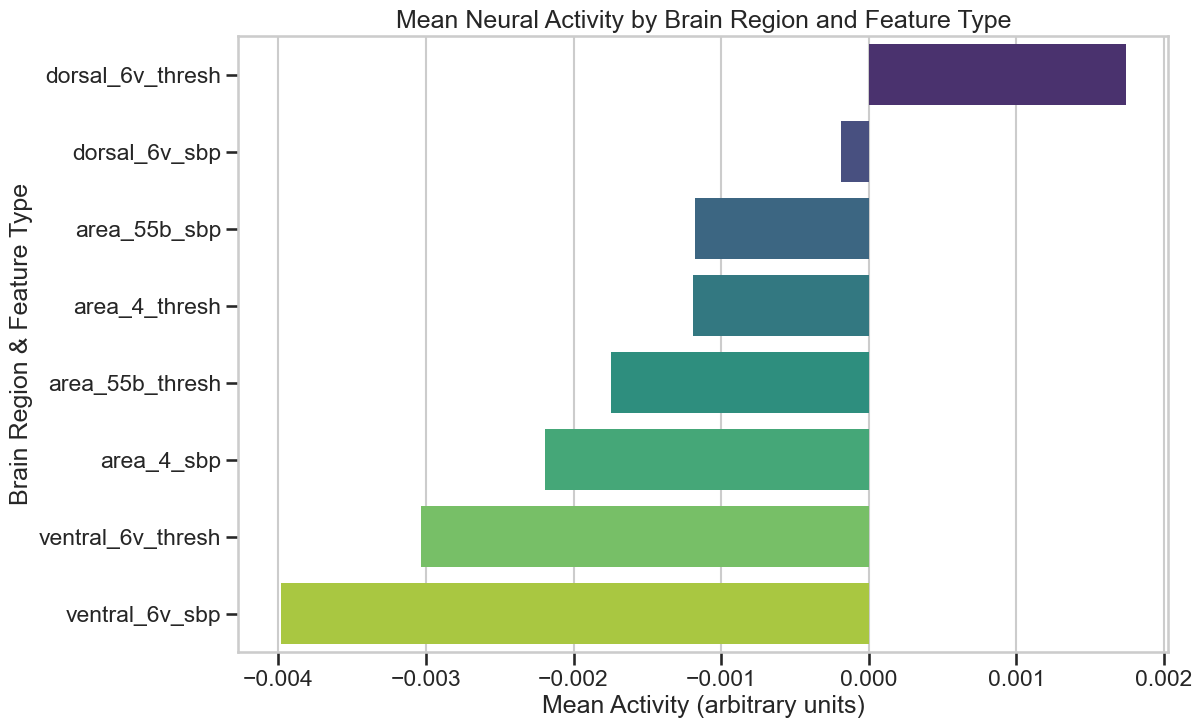

In [18]:
# --- Define feature mappings (this part is still correct) ---
FEATURE_MAP = {
    'ventral_6v_thresh': list(range(0, 64)),
    'area_4_thresh': list(range(64, 128)),
    'area_55b_thresh': list(range(128, 192)),
    'dorsal_6v_thresh': list(range(192, 256)),
    'ventral_6v_sbp': list(range(256, 320)),
    'area_4_sbp': list(range(320, 384)),
    'area_55b_sbp': list(range(384, 448)),
    'dorsal_6v_sbp': list(range(448, 512)),
}

# --- Load a sample of neural data (CORRECTED) ---
sample_sessions = session_dirs[:5]
all_neural_data = []

# Use the correct key name for neural data
NEURAL_DATA_KEY = 'input_features'

for session in tqdm(sample_sessions, desc="Loading Neural Data Sample"):
    session_path = os.path.join(BASE_DIR, session)
    file_path = os.path.join(session_path, 'data_train.hdf5')
    if os.path.exists(file_path):
        with h5py.File(file_path, 'r') as f:
            # Iterate through trial keys at the top level
            for trial_key in list(f.keys()):
                trial_group = f[trial_key]
                if isinstance(trial_group, h5py.Group) and NEURAL_DATA_KEY in trial_group:
                    all_neural_data.append(trial_group[NEURAL_DATA_KEY][()])

# Concatenate all time steps from all trials
if all_neural_data:
    full_neural_matrix = np.concatenate(all_neural_data, axis=0)
    print(f"Loaded a sample of {full_neural_matrix.shape[0]} time steps.")

    # --- Calculate and plot mean activity ---
    mean_activity = {name: full_neural_matrix[:, indices].mean() for name, indices in FEATURE_MAP.items()}
    mean_activity_df = pd.DataFrame(list(mean_activity.items()), columns=['Region_Feature', 'Mean_Activity'])
    mean_activity_df = mean_activity_df.sort_values('Mean_Activity', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=mean_activity_df, y='Region_Feature', x='Mean_Activity', palette='viridis')
    plt.title('Mean Neural Activity by Brain Region and Feature Type')
    plt.xlabel('Mean Activity (arbitrary units)')
    plt.ylabel('Brain Region & Feature Type')
    plt.show()
else:
    print("Could not load any neural data for the sample.")

In [19]:
markdown_text = """
### **Part 5: Connecting Neural Activity to Speech**
Let's tie it all together by visualizing a single trial. We'll plot the neural activity over time and align it with the sentence that was being spoken.
"""

display(Markdown(markdown_text))


### **Part 5: Connecting Neural Activity to Speech**
Let's tie it all together by visualizing a single trial. We'll plot the neural activity over time and align it with the sentence that was being spoken.


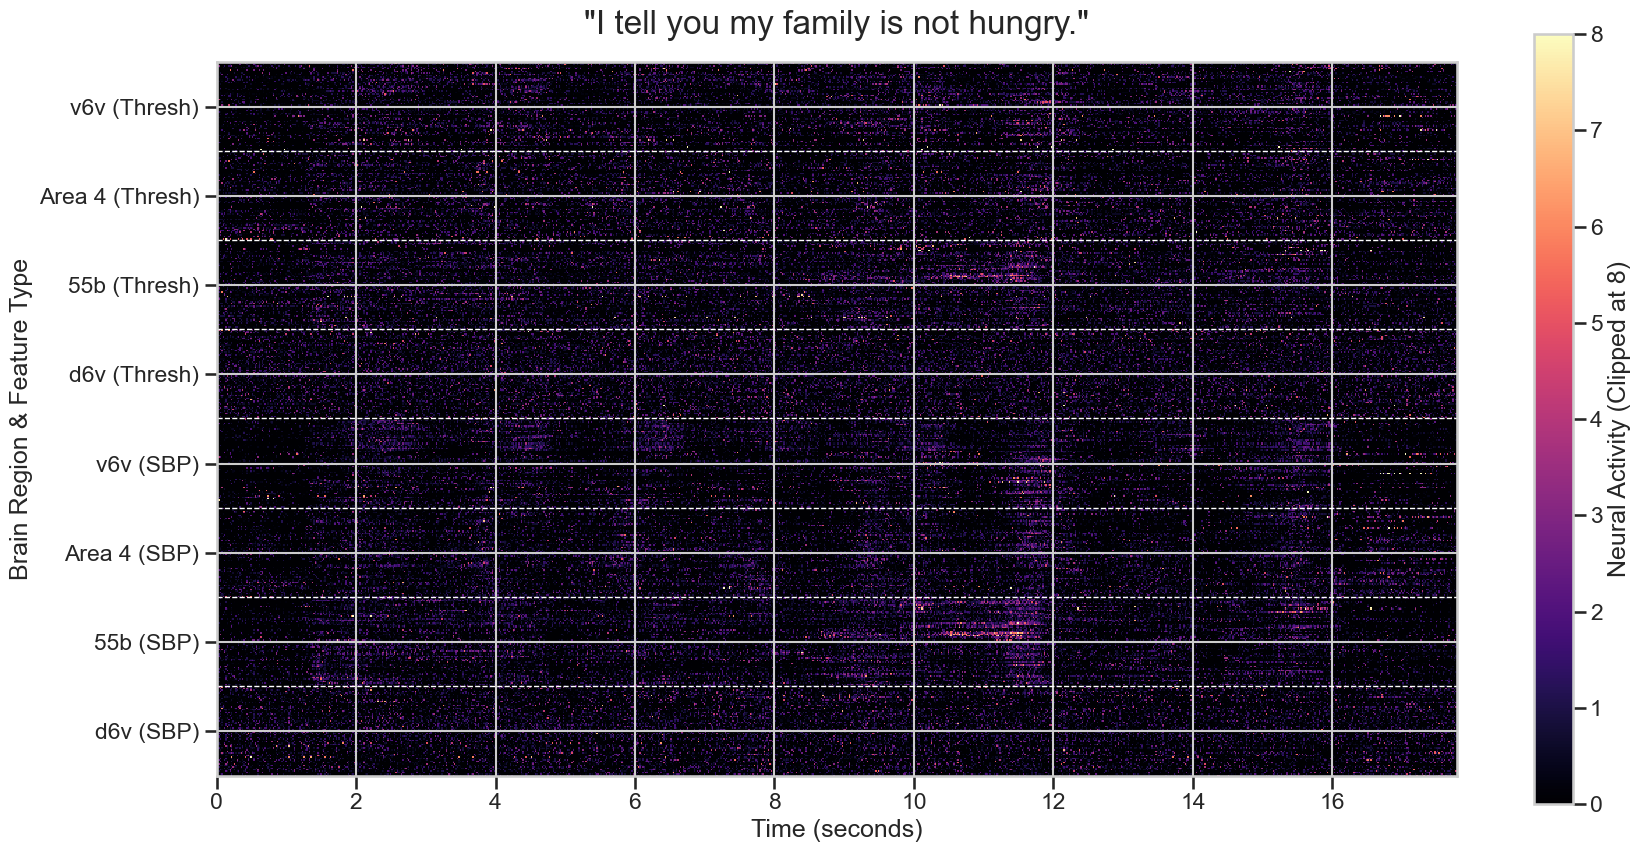

In [20]:
def plot_single_trial(session, trial_id):
    """ 
    Loads and plots a single trial's neural data and sentence,
    optimizing for visibility of neural activity spikes.
    """
    # Find the correct file and load the data (no changes here)
    row = df[(df['session'] == session) & (df['trial_id'] == trial_id)].iloc[0]
    split = row['split']
    file_path = os.path.join(BASE_DIR, session, f'data_{split}.hdf5')
    
    NEURAL_DATA_KEY = 'input_features'
    
    with h5py.File(file_path, 'r') as f:
        trial_group = f[trial_id]
        neural_data = trial_group[NEURAL_DATA_KEY][()]
        sentence = row['sentence_text']

    # --- Plotting Enhancements ---
    
    # 1. Create a proper time axis in seconds for the x-axis
    time_in_seconds = np.arange(neural_data.shape[0]) * 0.02
    
    plt.figure(figsize=(20, 10))
    
    # 2. Use imshow with parameters for better visibility
    plt.imshow(
        neural_data.T,
        aspect=0.02,  # Stretch the plot horizontally to make spikes wider
        cmap='magma', # A colormap with high contrast (dark background, bright spikes)
        interpolation='none',
        vmin=0,       # Set the minimum color value to 0 to ignore negative noise
        vmax=8,       # Clip the max color value to make spikes pop 
        extent=[time_in_seconds[0], time_in_seconds[-1], neural_data.shape[1], 0] # Correctly scale axes
    )
    
    # Add lines to separate the brain regions
    for i in [64, 128, 192, 256, 320, 384, 448]:
        plt.axhline(y=i-0.5, color='white', linestyle='--', linewidth=1)
        
    plt.colorbar(label='Neural Activity (Clipped at 8)')
    plt.yticks(
        ticks=[32, 96, 160, 224, 288, 352, 416, 480],
        labels=[
            'v6v (Thresh)', 'Area 4 (Thresh)', '55b (Thresh)', 'd6v (Thresh)',
            'v6v (SBP)', 'Area 4 (SBP)', '55b (SBP)', 'd6v (SBP)'
        ],
        rotation=0
    )
    plt.xlabel('Time (seconds)') # labeled in seconds
    plt.ylabel('Brain Region & Feature Type')
    plt.title(f'"{sentence}"', fontsize=24, pad=20)
    plt.show()

# --- Call the function ---
# Pick a trial to visualize
example_trial_info = df.dropna(subset=['num_words'])[df['num_words'] > 5].iloc[0]
plot_single_trial(example_trial_info['session'], example_trial_info['trial_id'])

In [21]:
caption = """
**Insight**: These heatmaps give us a feel for the raw data. We can see bursts of activity across many channels that are presumably correlated with the attempted speech. The complex, high-dimensional nature of the data is clear—this is not a simple problem! The patterns are subtle and distributed across all recorded areas, highlighting the need for powerful models like the RNNs or Transformers.
"""
display(Markdown(caption))


**Insight**: These heatmaps give us a feel for the raw data. We can see bursts of activity across many channels that are presumably correlated with the attempted speech. The complex, high-dimensional nature of the data is clear—this is not a simple problem! The patterns are subtle and distributed across all recorded areas, highlighting the need for powerful models like the RNNs or Transformers.


In [22]:
from IPython.display import Image, display,  Markdown

url = "https://www.nejm.org/cms/10.1056/NEJMoa2314132/asset/d30ecc79-8189-4964-8b25-a111d28d9b63/assets/images/large/nejmoa2314132_f3.jpg"

display(Image(url=url))

caption = """
A photograph of the participant using the speech neuroprosthesis in conversation mode is shown. The neuroprosthesis detected when 
the participant was trying to speak solely on the basis of neural activity and concluded either after 6 seconds of speech inactivity or on 
his optional activation of an on-screen button through eye tracking. After the decoded sentence was finalized, the participant selected 
on-screen confirmation buttons through eye tracking to indicate whether the decoded sentence was correct.
"""
display(Markdown(caption))


A photograph of the participant using the speech neuroprosthesis in conversation mode is shown. The neuroprosthesis detected when 
the participant was trying to speak solely on the basis of neural activity and concluded either after 6 seconds of speech inactivity or on 
his optional activation of an on-screen button through eye tracking. After the decoded sentence was finalized, the participant selected 
on-screen confirmation buttons through eye tracking to indicate whether the decoded sentence was correct.


In [23]:
caption = """
## Conclusion & Next Steps

This exploration has revealed several key characteristics of the Brain-to-Text '25 dataset:

1.  **Challenging Vocabulary**: With over 10,000 unique words, this is a large-vocabulary speech decoding task.
2.  **Variable Speaking Rate**: The bimodal distribution of WPM is a critical finding, suggesting that models must handle different speaking strategies (vocalized vs. silent).
3.  **Informative Neural Features**: All targeted brain regions show significant activity, validating the implant locations and suggesting that all 512 features could be useful.

-------
Good luck, and may your models decode with high fidelity. :) 

-------

**Give the notebook an upvote if you find it helpful. THANKS.**

-------
"""
display(Markdown(caption))


## Conclusion & Next Steps

This exploration has revealed several key characteristics of the Brain-to-Text '25 dataset:

1.  **Challenging Vocabulary**: With over 10,000 unique words, this is a large-vocabulary speech decoding task.
2.  **Variable Speaking Rate**: The bimodal distribution of WPM is a critical finding, suggesting that models must handle different speaking strategies (vocalized vs. silent).
3.  **Informative Neural Features**: All targeted brain regions show significant activity, validating the implant locations and suggesting that all 512 features could be useful.

-------
Good luck, and may your models decode with high fidelity. :) 

-------

**Give the notebook an upvote if you find it helpful. THANKS.**

-------


In [27]:
train_df['neural_data'].head()

0    [[2.3076649, -0.78699756, -0.64687246, -0.5465877, 0.25500455, -0.37754795, -0.31888878, -0.4374...
1    [[-0.51709145, -0.70207363, -0.64330804, -0.4804889, -0.74278086, -0.3836035, 4.4708495, -0.3822...
2    [[0.95464545, -0.6912571, 2.5334082, -0.45932075, -0.6866933, -0.36051196, -0.31188744, -0.38424...
3    [[-0.4997814, -0.6836047, -0.6305947, 1.2600378, 1.6435596, -0.36407253, -0.2934556, -0.37197226...
4    [[-0.4850082, -0.66607094, -0.62398034, -0.43359536, -0.6746259, -0.36549258, -0.2977266, -0.369...
Name: neural_data, dtype: object

In [24]:


# Установка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

# Посимвольный токенизатор
class CharTokenizer:
    def __init__(self):
        # Создаем словарь символов
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0
        
    def build_vocab(self, texts):
        """Строит словарь на основе текстов"""
        all_chars = set()
        for text in texts:
            all_chars.update(text)
        
        # Добавляем специальные токены
        special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
        all_chars.update(special_tokens)
        
        # Создаем маппинги
        self.char_to_idx = {char: idx for idx, char in enumerate(sorted(all_chars))}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
        print(f"Размер словаря: {self.vocab_size}")
        print(f"Символы: {list(self.char_to_idx.keys())}")
        
    def encode(self, text):
        """Кодирует текст в индексы"""
        return [self.char_to_idx.get(char, self.char_to_idx['<UNK>']) for char in text]
    
    def decode(self, indices):
        """Декодирует индексы в текст"""
        return ''.join([self.idx_to_char.get(idx, '<UNK>') for idx in indices])

# Dataset класс
class BrainTextDataset(Dataset):
    def __init__(self, df, tokenizer, max_neural_length=2000, max_text_length=200):
        self.df = df
        self.tokenizer = tokenizer
        self.max_neural_length = max_neural_length
        self.max_text_length = max_text_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Нейронные данные
        neural_data = row['neural_data']  # (time_bins, features)
        
        # Обрезаем или паддим нейронные данные
        if neural_data.shape[0] > self.max_neural_length:
            neural_data = neural_data[:self.max_neural_length]
        else:
            # Паддим нулями
            padding = np.zeros((self.max_neural_length - neural_data.shape[0], neural_data.shape[1]))
            neural_data = np.vstack([neural_data, padding])
        
        # Текст
        text = row['transcription'] if 'transcription' in row else row.get('sentence_text', '')
        
        # Токенизируем текст
        text_tokens = self.tokenizer.encode(text)
        
        # Добавляем SOS и EOS токены
        sos_token = self.tokenizer.char_to_idx['<SOS>']
        eos_token = self.tokenizer.char_to_idx['<EOS>']
        
        # Создаем входную и целевую последовательности
        input_tokens = [sos_token] + text_tokens
        target_tokens = text_tokens + [eos_token]
        
        # Обрезаем или паддим текстовые последовательности
        if len(input_tokens) > self.max_text_length:
            input_tokens = input_tokens[:self.max_text_length]
            target_tokens = target_tokens[:self.max_text_length]
        else:
            pad_token = self.tokenizer.char_to_idx['<PAD>']
            input_tokens.extend([pad_token] * (self.max_text_length - len(input_tokens)))
            target_tokens.extend([pad_token] * (self.max_text_length - len(target_tokens)))
        
        return {
            'neural_data': torch.FloatTensor(neural_data),
            'input_tokens': torch.LongTensor(input_tokens),
            'target_tokens': torch.LongTensor(target_tokens),
            'text': text
        }

# Позиционное кодирование
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Основная модель трансформера
class BrainToTextTransformer(nn.Module):
    def __init__(self, neural_features, vocab_size, d_model=512, nhead=8, num_layers=6, max_text_length=200):
        super().__init__()
        
        self.d_model = d_model
        self.max_text_length = max_text_length
        
        # Энкодер для нейронных данных
        self.neural_encoder = nn.Sequential(
            nn.Linear(neural_features, d_model),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Эмбеддинг для текста
        self.text_embedding = nn.Embedding(vocab_size, d_model)
        
        # Позиционное кодирование
        self.pos_encoding = PositionalEncoding(d_model, max_text_length)
        
        # Трансформер декодер
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=2048,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        
        # Выходной слой
        self.output_projection = nn.Linear(d_model, vocab_size)
        
    def forward(self, neural_data, input_tokens):
        batch_size = neural_data.size(0)
        
        # Кодируем нейронные данные
        neural_encoded = self.neural_encoder(neural_data)  # (batch, time, d_model)
        
        # Эмбеддинг текста
        text_embedded = self.text_embedding(input_tokens)  # (batch, seq_len, d_model)
        
        # Добавляем позиционное кодирование
        text_embedded = self.pos_encoding(text_embedded.transpose(0, 1)).transpose(0, 1)
        
        # Создаем маску для предотвращения "заглядывания в будущее"
        tgt_mask = self.generate_square_subsequent_mask(input_tokens.size(1)).to(neural_data.device)
        
        # Трансформер декодер
        decoder_output = self.transformer_decoder(
            text_embedded,
            neural_encoded,
            tgt_mask=tgt_mask
        )
        
        # Выходные вероятности
        output = self.output_projection(decoder_output)
        
        return output
    
    def generate_square_subsequent_mask(self, sz):
        """Создает маску для предотвращения заглядывания в будущее"""
        mask = torch.triu(torch.ones(sz, sz)) == 1
        mask = mask.transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def generate(self, neural_data, tokenizer, max_length=200, temperature=1.0):
        """Генерирует текст на основе нейронных данных"""
        self.eval()
        with torch.no_grad():
            batch_size = neural_data.size(0)
            device = neural_data.device
            
            # Начинаем с SOS токена
            sos_token = tokenizer.char_to_idx['<SOS>']
            generated = torch.full((batch_size, 1), sos_token, dtype=torch.long, device=device)
            
            for _ in range(max_length):
                # Получаем предсказания
                output = self.forward(neural_data, generated)
                
                # Берем последний токен
                next_token_logits = output[:, -1, :] / temperature
                
                # Применяем softmax и сэмплируем
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Добавляем к сгенерированной последовательности
                generated = torch.cat([generated, next_token], dim=1)
                
                # Останавливаемся если все последовательности закончились на EOS
                if (next_token == tokenizer.char_to_idx['<EOS>']).all():
                    break
            
            return generated

print("Модель и классы созданы успешно!")


Используется устройство: cpu
Модель и классы созданы успешно!


In [25]:
# Подготовка данных и обучение модели
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Подготовка данных
print("Подготовка данных...")

# Создаем токенизатор
tokenizer = CharTokenizer()

# Собираем все тексты для построения словаря
all_texts = []
for idx, row in train_df.iterrows():
    text = row['transcription'] if 'transcription' in row else row.get('sentence_text', '')
    if text and len(text.strip()) > 0:
        all_texts.append(text)

print(f"Найдено {len(all_texts)} текстов для обучения")

# Строим словарь
tokenizer.build_vocab(all_texts)

# Разделяем данные на train/validation
train_texts, val_texts = train_test_split(all_texts, test_size=0.2, random_state=42)

# Создаем датасеты
train_dataset = BrainTextDataset(
    train_df[train_df['transcription'].isin(train_texts)] if 'transcription' in train_df.columns 
    else train_df[train_df['sentence_text'].isin(train_texts)],
    tokenizer,
    max_neural_length=2000,
    max_text_length=200
)

val_dataset = BrainTextDataset(
    train_df[train_df['transcription'].isin(val_texts)] if 'transcription' in train_df.columns 
    else train_df[train_df['sentence_text'].isin(val_texts)],
    tokenizer,
    max_neural_length=2000,
    max_text_length=200
)

# Создаем DataLoader'ы
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

# Создаем модель
neural_features = train_df.iloc[0]['neural_data'].shape[1]  # Количество датчиков
model = BrainToTextTransformer(
    neural_features=neural_features,
    vocab_size=tokenizer.vocab_size,
    d_model=256,  # Уменьшаем для экономии памяти
    nhead=8,
    num_layers=4,  # Уменьшаем количество слоев
    max_text_length=200
).to(device)

print(f"Модель создана:")
print(f"- Нейронные признаки: {neural_features}")
print(f"- Размер словаря: {tokenizer.vocab_size}")
print(f"- Параметры модели: {sum(p.numel() for p in model.parameters()):,}")

# Оптимизатор и функция потерь
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.char_to_idx['<PAD>'])

# Функция для вычисления метрик
def calculate_metrics(predictions, targets, tokenizer):
    """Вычисляет метрики качества"""
    # Убираем паддинг токены
    pad_token = tokenizer.char_to_idx['<PAD>']
    eos_token = tokenizer.char_to_idx['<EOS>']
    
    total_tokens = 0
    correct_tokens = 0
    
    for pred, target in zip(predictions, targets):
        # Находим где заканчивается реальная последовательность
        target_len = (target != pad_token).sum().item()
        if target_len > 0:
            pred_tokens = pred[:target_len]
            target_tokens = target[:target_len]
            
            total_tokens += target_len
            correct_tokens += (pred_tokens == target_tokens).sum().item()
    
    accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    return accuracy

# Функция для валидации
def validate_model(model, val_loader, criterion, tokenizer, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in val_loader:
            neural_data = batch['neural_data'].to(device)
            input_tokens = batch['input_tokens'].to(device)
            target_tokens = batch['target_tokens'].to(device)
            
            # Forward pass
            outputs = model(neural_data, input_tokens)
            
            # Вычисляем потери
            loss = criterion(outputs.view(-1, outputs.size(-1)), target_tokens.view(-1))
            total_loss += loss.item()
            
            # Вычисляем точность
            predictions = torch.argmax(outputs, dim=-1)
            accuracy = calculate_metrics(predictions, target_tokens, tokenizer)
            total_accuracy += accuracy
            
            num_batches += 1
    
    return total_loss / num_batches, total_accuracy / num_batches

print("Данные подготовлены, модель готова к обучению!")


Подготовка данных...
Найдено 8072 текстов для обучения
Размер словаря: 66
Символы: [' ', '!', "'", ',', '-', '.', ';', '<EOS>', '<PAD>', '<SOS>', '<UNK>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '’']
Размер обучающей выборки: 6696
Размер валидационной выборки: 1894
Модель создана:
- Нейронные признаки: 512
- Размер словаря: 66
- Параметры модели: 6,545,986
Данные подготовлены, модель готова к обучению!


In [26]:
# Цикл обучения
num_epochs = 10
best_val_loss = float('inf')
patience = 3
patience_counter = 0

# Списки для сохранения метрик
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Начинаем обучение...")
print(f"Количество эпох: {num_epochs}")
print(f"Размер батча: {batch_size}")
print(f"Устройство: {device}")

for epoch in range(num_epochs):
    # Обучение
    model.train()
    train_loss = 0
    train_accuracy = 0
    num_train_batches = 0
    
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    
    for batch in train_pbar:
        neural_data = batch['neural_data'].to(device)
        input_tokens = batch['input_tokens'].to(device)
        target_tokens = batch['target_tokens'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(neural_data, input_tokens)
        
        # Вычисляем потери
        loss = criterion(outputs.view(-1, outputs.size(-1)), target_tokens.view(-1))
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Вычисляем метрики
        train_loss += loss.item()
        predictions = torch.argmax(outputs, dim=-1)
        accuracy = calculate_metrics(predictions, target_tokens, tokenizer)
        train_accuracy += accuracy
        num_train_batches += 1
        
        # Обновляем прогресс бар
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{accuracy:.4f}'
        })
    
    # Валидация
    val_loss, val_accuracy = validate_model(model, val_loader, criterion, tokenizer, device)
    
    # Сохраняем метрики
    avg_train_loss = train_loss / num_train_batches
    avg_train_accuracy = train_accuracy / num_train_batches
    
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(avg_train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Сохраняем лучшую модель
        torch.save(model.state_dict(), 'best_brain_to_text_model.pth')
        print(f'  ✓ Новая лучшая модель сохранена!')
    else:
        patience_counter += 1
        print(f'  Patience: {patience_counter}/{patience}')
        
        if patience_counter >= patience:
            print(f'  Early stopping! Лучшая валидационная потеря: {best_val_loss:.4f}')
            break
    
    print('-' * 50)

# Загружаем лучшую модель
model.load_state_dict(torch.load('best_brain_to_text_model.pth'))
print("Обучение завершено! Лучшая модель загружена.")

# Визуализация метрик
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Финальные метрики:")
print(f"Лучшая валидационная потеря: {best_val_loss:.4f}")
print(f"Финальная валидационная точность: {val_accuracies[-1]:.4f}")


Начинаем обучение...
Количество эпох: 10
Размер батча: 8
Устройство: cpu


Epoch 1/10 [Train]:   0%|          | 0/837 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Функции для инференса и тестирования
import re

def clean_generated_text(text):
    """Очищает сгенерированный текст от служебных токенов"""
    # Убираем служебные токены
    text = re.sub(r'<SOS>|<EOS>|<PAD>|<UNK>', '', text)
    # Убираем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def generate_text(model, neural_data, tokenizer, max_length=200, temperature=1.0):
    """Генерирует текст на основе нейронных данных"""
    model.eval()
    
    # Подготавливаем нейронные данные
    if isinstance(neural_data, np.ndarray):
        neural_data = torch.FloatTensor(neural_data).unsqueeze(0)  # Добавляем batch dimension
    
    # Обрезаем или паддим до нужной длины
    max_neural_length = 2000
    if neural_data.shape[1] > max_neural_length:
        neural_data = neural_data[:, :max_neural_length, :]
    else:
        padding = torch.zeros(1, max_neural_length - neural_data.shape[1], neural_data.shape[2])
        neural_data = torch.cat([neural_data, padding], dim=1)
    
    neural_data = neural_data.to(device)
    
    # Генерируем текст
    with torch.no_grad():
        generated_tokens = model.generate(neural_data, tokenizer, max_length, temperature)
        
        # Декодируем в текст
        generated_text = tokenizer.decode(generated_tokens[0].cpu().numpy())
        generated_text = clean_generated_text(generated_text)
        
    return generated_text

def test_model_on_samples(model, dataset, tokenizer, num_samples=5):
    """Тестирует модель на нескольких примерах"""
    model.eval()
    
    print("Тестирование модели на примерах:")
    print("=" * 80)
    
    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        
        # Получаем исходные данные
        neural_data = sample['neural_data'].unsqueeze(0).to(device)
        original_text = sample['text']
        
        # Генерируем текст
        generated_text = generate_text(model, neural_data, tokenizer, temperature=0.8)
        
        print(f"Пример {i+1}:")
        print(f"Исходный текст: '{original_text}'")
        print(f"Сгенерированный: '{generated_text}'")
        print("-" * 40)

def calculate_bleu_score(predictions, references, tokenizer):
    """Вычисляет BLEU score (упрощенная версия)"""
    from collections import Counter
    
    def get_ngrams(text, n):
        words = text.split()
        return [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    
    def calculate_precision(pred_ngrams, ref_ngrams):
        pred_counts = Counter(pred_ngrams)
        ref_counts = Counter(ref_ngrams)
        
        overlap = 0
        for ngram in pred_counts:
            overlap += min(pred_counts[ngram], ref_counts.get(ngram, 0))
        
        return overlap / len(pred_ngrams) if pred_ngrams else 0
    
    total_score = 0
    for pred, ref in zip(predictions, references):
        pred_clean = clean_generated_text(pred)
        ref_clean = clean_generated_text(ref)
        
        # Вычисляем BLEU-1 (1-gram precision)
        pred_1grams = get_ngrams(pred_clean, 1)
        ref_1grams = get_ngrams(ref_clean, 1)
        
        precision = calculate_precision(pred_1grams, ref_1grams)
        total_score += precision
    
    return total_score / len(predictions) if predictions else 0

# Тестируем модель
print("Тестирование обученной модели...")
test_model_on_samples(model, val_dataset, tokenizer, num_samples=3)

# Дополнительная оценка на валидационной выборке
print("\nОценка на валидационной выборке:")
model.eval()
val_predictions = []
val_references = []

with torch.no_grad():
    for i, sample in enumerate(val_dataset):
        if i >= 20:  # Ограничиваем для скорости
            break
            
        neural_data = sample['neural_data'].unsqueeze(0).to(device)
        original_text = sample['text']
        
        generated_text = generate_text(model, neural_data, tokenizer, temperature=0.8)
        
        val_predictions.append(generated_text)
        val_references.append(original_text)

# Вычисляем BLEU score
bleu_score = calculate_bleu_score(val_predictions, val_references, tokenizer)
print(f"BLEU-1 Score: {bleu_score:.4f}")

# Показываем несколько примеров
print("\nПримеры предсказаний:")
for i in range(min(5, len(val_predictions))):
    print(f"{i+1}. Исходный: '{val_references[i]}'")
    print(f"   Предсказанный: '{val_predictions[i]}'")
    print()

print("Тестирование завершено!")
